In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [ ]:
df = pd.read_csv('/content/housing.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
corr_matrix = df.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

```
let's drop total_bedrooms since it have less correlation and has 207 Nan values.
```

In [ ]:
housing = df.drop(['total_bedrooms'], axis = 1)

In [ ]:
# lets try adding new features
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing.head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household
0,-122.23,37.88,41.0,880.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127
1,-122.22,37.86,21.0,7099.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137
2,-122.24,37.85,52.0,1467.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136
3,-122.25,37.85,52.0,1274.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5.817352
4,-122.25,37.85,52.0,1627.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6.281853


In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.688075
rooms_per_household    0.151948
total_rooms            0.134153
housing_median_age     0.105623
households             0.065843
population            -0.024650
longitude             -0.045967
latitude              -0.144160
Name: median_house_value, dtype: float64

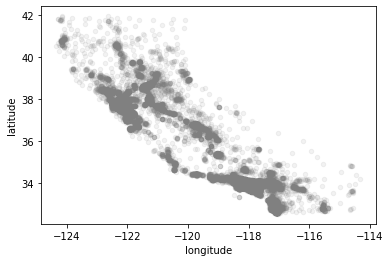


----------



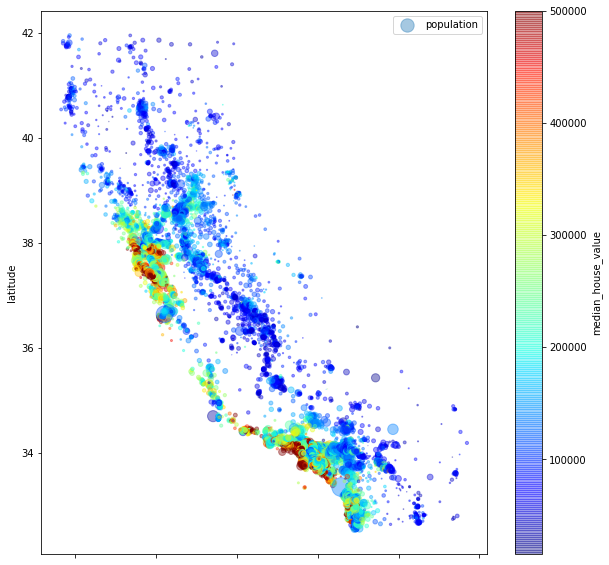

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, color='grey')
# alpha = 0.1 helps visualize high density regions
plt.show()

print('\n'+'----------'+'\n')
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
 s=housing["population"]/100, label="population", figsize=(10,10),
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()
plt.show()

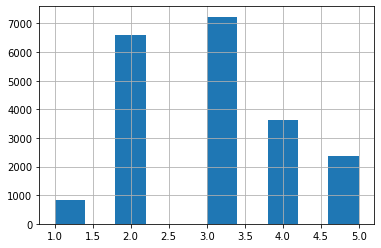

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()
plt.show()

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

#After using this income category to efficiently split the data drop it.

for set_ in (strat_train_set, strat_test_set):
 set_.drop("income_cat", axis=1, inplace=True)

strat_test_set.head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household
5241,-118.39,34.12,29.0,6447.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN,6.715625
17352,-120.42,34.89,24.0,2020.0,855.0,283.0,5.0099,162500.0,<1H OCEAN,7.137809
3505,-118.45,34.25,36.0,1453.0,808.0,275.0,4.3839,204600.0,<1H OCEAN,5.283636
7777,-118.10,33.91,35.0,1653.0,1072.0,301.0,3.2708,159700.0,<1H OCEAN,5.491694
14155,-117.07,32.77,38.0,3779.0,1495.0,614.0,4.3529,184000.0,NEAR OCEAN,6.154723


In [ ]:
# now lets split the predictors and targets and
# prepare our data for model
X_train = strat_train_set.drop("median_house_value", axis=1)
y_train = strat_train_set["median_house_value"].copy()

In [ ]:
# separating numerical and object values for data cleaning
housing_num = X_train.drop("ocean_proximity", axis=1)
housing_cat = X_train[["ocean_proximity"]]

In [ ]:
# creating a pipeline
# 1. create a model
model = RandomForestRegressor(n_estimators = 10, random_state = 42)

# 2. preprocess the data
#     numerical transformer
num_attribs = list(housing_num)
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
 ])
#     categorical transformer
cat_attribs = ["ocean_proximity"] # or housing_cat since both are just column names
cat_pipeline = Pipeline(steps = [
    ('one_hot', OneHotEncoder(handle_unknown = 'ignore')),
])
#  preprocessing both
preprocessor = ColumnTransformer(transformers = [
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
])

#pipeline
my_pipeline = Pipeline(steps = [
    ('preprocessor',preprocessor),
    ('model',model)
])

In [ ]:
my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income',
                                                   'rooms_per_household']),
                                                 ('cat',
                                                  Pipeline(steps=[

In [ ]:
# now lets split the predictors and targets and
# prepare our data for model
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

In [ ]:
prediction = my_pipeline.predict(X_test)
score = mean_absolute_error(y_test, prediction)
print('MAE:', score)

MAE: 33453.08987403101
